Import thư viện

In [ ]:
# import thư viện
import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     Concatenate, Dropout, GlobalAveragePooling2D, Dense)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from google.colab import drive

Load và chia dữ liệu

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

#Path
base_dir = '/content/drive/MyDrive/ISIC_2018'
img_dir = os.path.join(base_dir, 'ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input')
csv_path = os.path.join(base_dir, 'ISIC2018_Task3_Training_GroundTruth.csv')

#Load Labels
labels_df = pd.read_csv(csv_path)
labels_df['label'] = labels_df.iloc[:, 1:].idxmax(axis=1)
labels_df = labels_df[['image', 'label']]
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
labels_df['label_idx'] = labels_df['label'].apply(lambda x: class_names.index(x))

train_val, test_df = train_test_split(labels_df, test_size=0.15, stratify=labels_df['label'], random_state=42)
train_df, val_df = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)


Mounted at /content/drive


In [ ]:
# === In thống kê dữ liệu ===

# Nội dung 5 dòng đầu của file CSV (chưa xử lý)
print(" Nội dung 5 dòng đầu của file CSV gốc:")
print(pd.read_csv(csv_path).head())

# Tổng số ảnh
print(f"\n Tổng số ảnh: {len(labels_df)}")

# Số lượng ảnh theo từng loại bệnh
print("\n Số lượng ảnh theo từng loại bệnh:")
print(labels_df['label'].value_counts())

# Số lượng ảnh trong từng tập
print(f"\n Số ảnh trong tập huấn luyện (train): {len(train_df)}")
print(f" Số ảnh trong tập kiểm tra (val): {len(val_df)}")
print(f" Số ảnh trong tập test: {len(test_df)}")



 Nội dung 5 dòng đầu của file CSV gốc:
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

 Tổng số ảnh: 10015

 Số lượng ảnh theo từng loại bệnh:
label
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64

 Số ảnh trong tập huấn luyện (train): 7013
 Số ảnh trong tập kiểm tra (val): 1499
 Số ảnh trong tập test: 1503


Tạo mask giả với Otsu

In [ ]:
#Otsu Mask
def create_otsu_mask(image_path, img_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    return img / 255.0, (mask / 255.0).astype(np.float32)


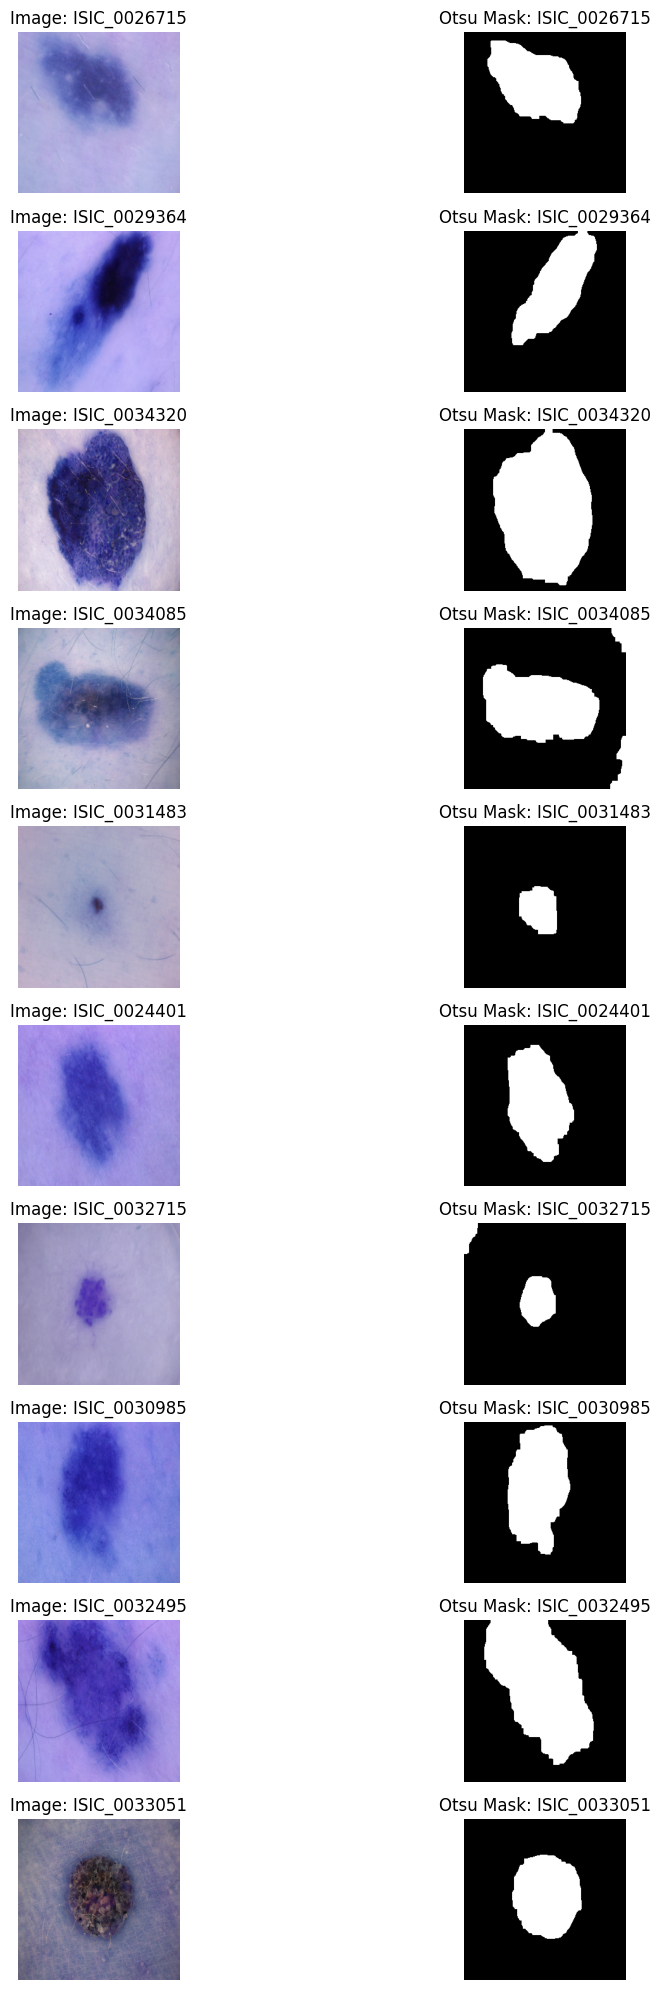

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#Hiển thị 10 ảnh và mask
sample_images = train_df['image'].sample(10, random_state=42).values

plt.figure(figsize=(12, 20))

for i, img_id in enumerate(sample_images):
    img_path = os.path.join(img_dir, img_id + '.jpg')
    img, mask = create_otsu_mask(img_path)

    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(img)
    plt.title(f'Image: {img_id}')
    plt.axis('off')

    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Otsu Mask: {img_id}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
Xây dựng model u-net

In [ ]:
#U-Net Model
def build_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
    u5 = UpSampling2D()(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(128, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(128, 3, activation='relu', padding='same')(c5)
    u6 = UpSampling2D()(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(64, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(64, 3, activation='relu', padding='same')(c6)
    u7 = UpSampling2D()(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(32, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(32, 3, activation='relu', padding='same')(c7)
    outputs = Conv2D(1, 1, activation='sigmoid')(c7)
    return Model(inputs, outputs)

class SegmentationSequence(Sequence):
    def __init__(self, df, batch_size=8, img_size=(256, 256)):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        imgs, masks = [], []
        for _, row in batch_df.iterrows():
            path = os.path.join(img_dir, row['image'] + ".jpg")
            img, mask = create_otsu_mask(path, self.img_size)
            imgs.append(img)
            masks.append(mask[..., np.newaxis])
        return np.array(imgs), np.array(masks)

In [ ]:
model = build_unet()
model.summary()  # 👈 In ra kiến trúc mạng U-Net và số tham số


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 1,946,881 (7.43 MB)

 Trainable params: 1,946,881 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

Train U-net. Vì chỉ thay đổi RestNet50 thành VGG16 nên em load checkpoint mô hình U-net đã train và lưu ở drive bên RestNet qua đẻ huấn luyện.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# Mount Drive nếu chưa mount
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn lưu checkpoint và file lưu số epoch
checkpoint_dir = '/content/drive/MyDrive/ISIC_2018/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
unet_ckpt_path = os.path.join(checkpoint_dir, 'unet_best.h5')
epoch_record_path = os.path.join(checkpoint_dir, 'epoch_record.txt')

# Hàm đọc số epoch đã train từ file
def read_epoch():
    if os.path.exists(epoch_record_path):
        with open(epoch_record_path, 'r') as f:
            return int(f.read())
    return 0

# Hàm lưu số epoch đã train vào file
def save_epoch(epoch):
    with open(epoch_record_path, 'w') as f:
        f.write(str(epoch))

# Đọc epoch đã train
initial_epoch = read_epoch()

if os.path.exists(unet_ckpt_path):
    print(f"Loading saved U-Net model from epoch {initial_epoch}...")
    unet_model = load_model(unet_ckpt_path)
else:
    print("Training U-Net from scratch...")
    unet_model = build_unet()
    unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    initial_epoch = 0

# Định nghĩa callback để lưu checkpoint và số epoch
class SaveEpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Lưu số epoch hiện tại (epoch bắt đầu từ 0 nên +1)
        save_epoch(epoch + 1)

ckpt = ModelCheckpoint(unet_ckpt_path, save_best_only=True, monitor='val_loss', verbose=1)

unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.fit(
    SegmentationSequence(train_df),
    validation_data=SegmentationSequence(val_df),
    epochs=10,
    initial_epoch=initial_epoch,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ckpt, SaveEpochCallback()]
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading saved U-Net model from epoch 7...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 8/10
 23/877 ━━━━━━━━━━━━━━━━━━━━ 3:38:57 15s/step - accuracy: 0.9331 - loss: 0.1686

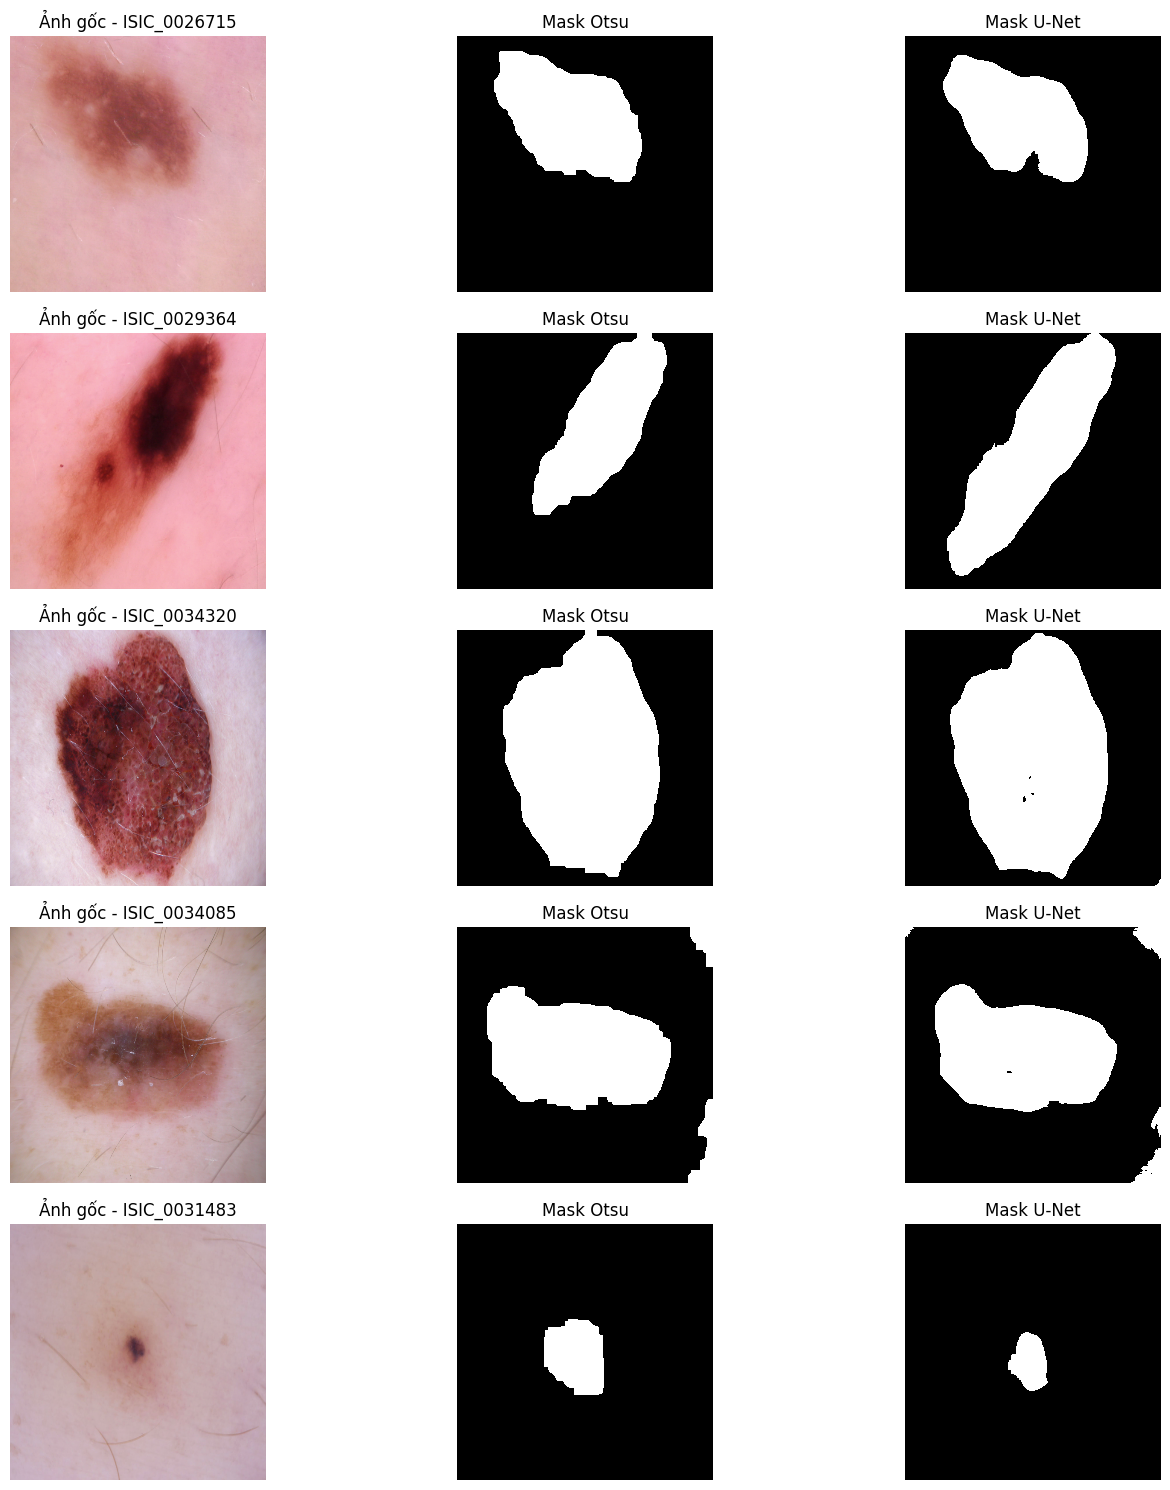

In [ ]:
# Hiển thị ảnh mask sau khi train
import matplotlib.pyplot as plt
import random
import os
import cv2
import numpy as np

def show_masks_comparison(df, model, num_samples=5, img_size=(256, 256)):
    sample_df = df.sample(num_samples, random_state=42).reset_index(drop=True)

    plt.figure(figsize=(15, num_samples * 3))

    for i in range(num_samples):
        image_id = sample_df.loc[i, 'image']
        img_path = os.path.join(img_dir, image_id + ".jpg")
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, img_size)

        # Mask Otsu
        gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, mask_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((5, 5), np.uint8)
        mask_otsu = cv2.morphologyEx(mask_otsu, cv2.MORPH_CLOSE, kernel, iterations=2)
        mask_otsu = cv2.morphologyEx(mask_otsu, cv2.MORPH_OPEN, kernel, iterations=2)

        # Mask từ U-Net
        input_img = img_resized / 255.0
        pred_mask = model.predict(np.expand_dims(input_img, axis=0), verbose=0)[0, ..., 0]
        mask_unet = (pred_mask > 0.5).astype(np.uint8) * 255

        # Hiển thị
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_resized)
        plt.title(f'Ảnh gốc - {image_id}')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask_otsu, cmap='gray')
        plt.title('Mask Otsu')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(mask_unet, cmap='gray')
        plt.title('Mask U-Net')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Gọi hàm với tập train hoặc val:
show_masks_comparison(train_df, unet_model, num_samples=5)


Sử dụng tập test để đánh giá

In [ ]:
# Sử dụng tập test để đánh giá mô hình
import numpy as np
import cv2
from tqdm import tqdm

# Hàm tính IoU
def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Hàm tính Dice coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
    return dice

# Đánh giá mô hình trên tập test
def evaluate_unet_on_test(df, model, img_dir, img_size=(256, 256)):
    iou_scores = []
    dice_scores = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(img_dir, row['image'] + ".jpg")
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Không tìm thấy ảnh: {img_path}")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, img_size) / 255.0

        # Tạo mask gốc bằng Otsu (xem như ground truth ước lượng)
        gray = cv2.cvtColor((img_resized * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, mask_true = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((5, 5), np.uint8)
        mask_true = cv2.morphologyEx(mask_true, cv2.MORPH_CLOSE, kernel, iterations=2)
        mask_true = cv2.morphologyEx(mask_true, cv2.MORPH_OPEN, kernel, iterations=2)
        mask_true = (mask_true / 255).astype(np.uint8)

        # Dự đoán mask U-Net
        pred_mask = model.predict(np.expand_dims(img_resized, axis=0), verbose=0)[0, ..., 0]
        mask_pred = (pred_mask > 0.5).astype(np.uint8)

        # Tính metric
        iou_scores.append(iou_score(mask_true, mask_pred))
        dice_scores.append(dice_coef(mask_true, mask_pred))

    print(f"Mean IoU trên tập test: {np.mean(iou_scores):.4f}")
    print(f"Mean Dice coefficient trên tập test: {np.mean(dice_scores):.4f}")

# Gọi hàm đánh giá
evaluate_unet_on_test(test_df, unet_model, img_dir)


100%|██████████| 1503/1503 [08:59<00:00,  2.78it/s]

Mean IoU trên tập test: 0.7711
Mean Dice coefficient trên tập test: 0.8512


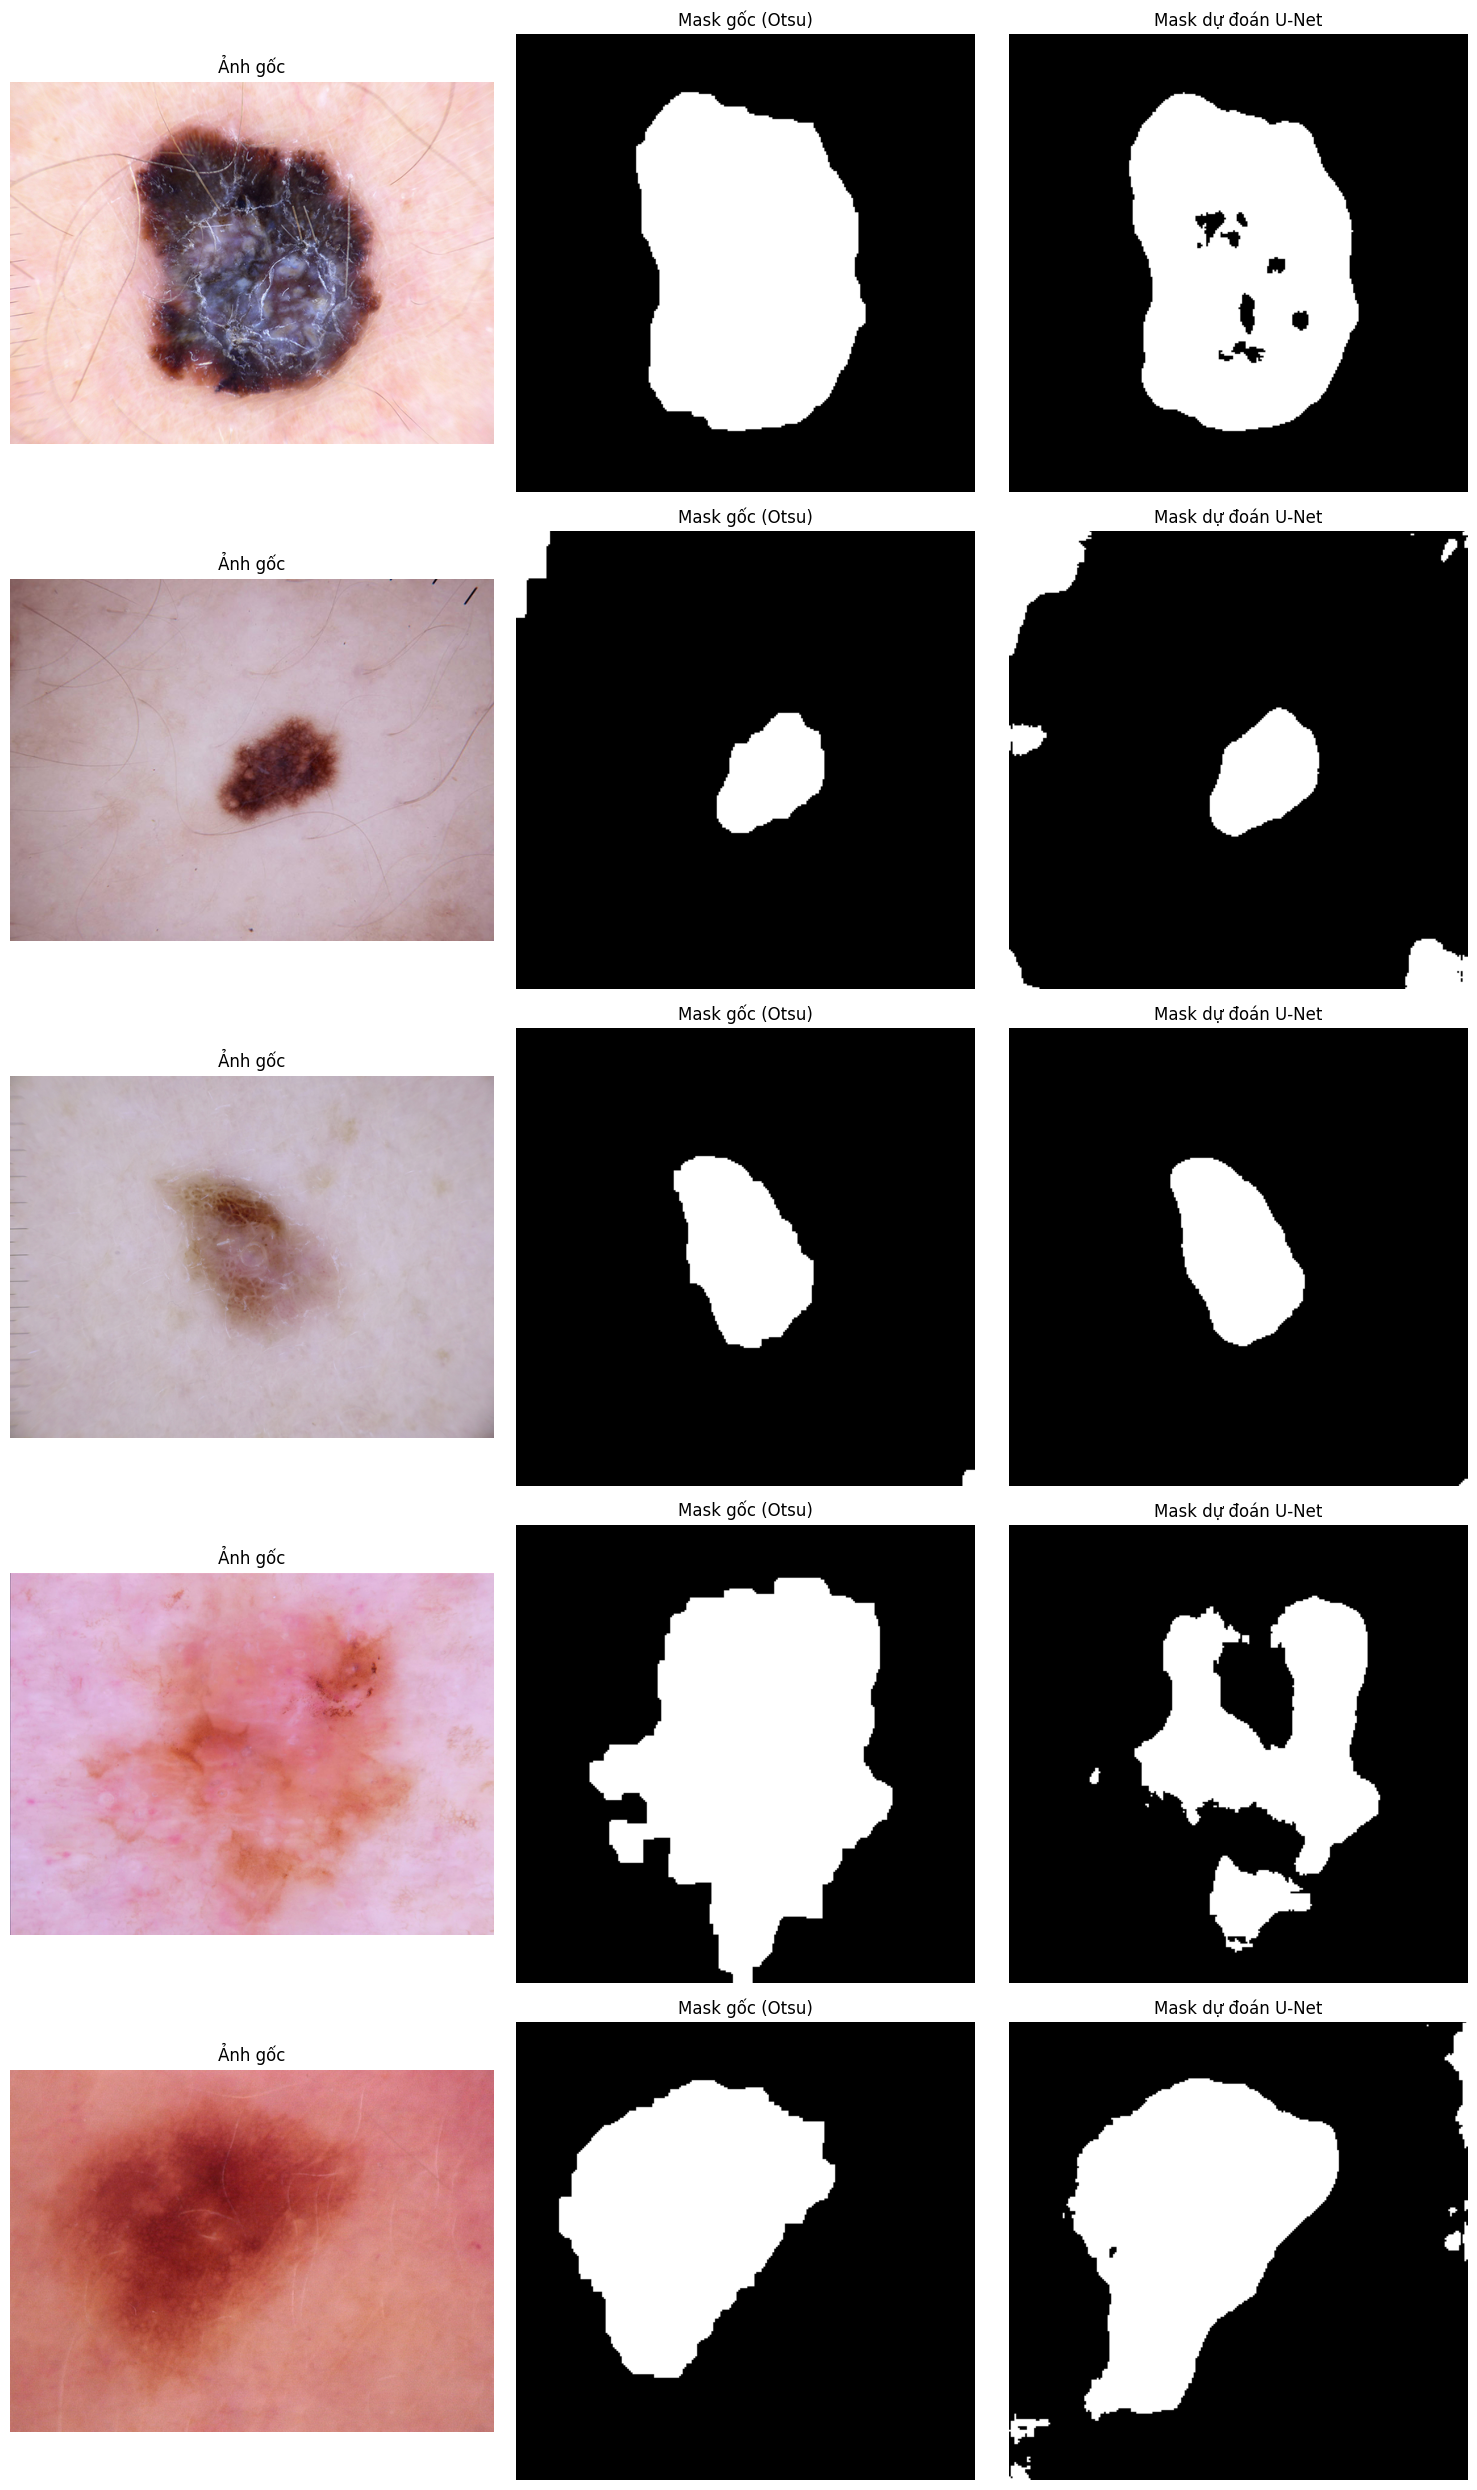

In [ ]:
import matplotlib.pyplot as plt

def show_test_predictions(df, model, img_dir, img_size=(256, 256), n=5):
    plt.figure(figsize=(15, n * 5))
    for i, (_, row) in enumerate(df.sample(n).iterrows()):
        img_path = os.path.join(img_dir, row['image'] + ".jpg")
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Không tìm thấy ảnh: {img_path}")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, img_size) / 255.0

        # Tạo mask gốc bằng Otsu
        gray = cv2.cvtColor((img_resized * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, mask_true = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((5, 5), np.uint8)
        mask_true = cv2.morphologyEx(mask_true, cv2.MORPH_CLOSE, kernel, iterations=2)
        mask_true = cv2.morphologyEx(mask_true, cv2.MORPH_OPEN, kernel, iterations=2)
        mask_true = (mask_true / 255).astype(np.uint8)

        # Dự đoán mask U-Net
        pred_mask = model.predict(np.expand_dims(img_resized, axis=0), verbose=0)[0, ..., 0]
        mask_pred = (pred_mask > 0.5).astype(np.uint8)

        # Hiển thị
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(img_rgb)
        plt.title('Ảnh gốc')
        plt.axis('off')

        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(mask_true, cmap='gray')
        plt.title('Mask gốc (Otsu)')
        plt.axis('off')

        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(mask_pred, cmap='gray')
        plt.title('Mask dự đoán U-Net')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Gọi hàm hiển thị
show_test_predictions(test_df, unet_model, img_dir, n=5)


Lưu ảnh có vùng tổn thương

In [ ]:
# === Save ROI Images ===
roi_dir = '/content/roi'
os.makedirs(roi_dir, exist_ok=True)

def extract_roi(img, mask_pred):
    coords = np.column_stack(np.where(mask_pred > 0))
    if coords.size == 0:
        return cv2.resize(img, (224, 224))
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    roi = img[y0:y1 + 1, x0:x1 + 1]
    return cv2.resize(roi, (224, 224))

def save_roi_images(df, seg_model, output_dir):
    for cls in range(7):
        os.makedirs(os.path.join(output_dir, str(cls)), exist_ok=True)
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['image'] + ".jpg")
        img = cv2.imread(img_path)
        pred = seg_model.predict(np.expand_dims(cv2.resize(img, (256, 256)) / 255.0, axis=0), verbose=0)[0, ..., 0]
        mask_pred = (pred > 0.5).astype(np.uint8)
        roi = extract_roi(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mask_pred)
        out_path = os.path.join(output_dir, str(row['label_idx']), f"{row['image']}.jpg")
        cv2.imwrite(out_path, (roi * 255).astype(np.uint8))

save_roi_images(train_df, unet_model, os.path.join(roi_dir, 'train'))
save_roi_images(val_df, unet_model, os.path.join(roi_dir, 'val'))
save_roi_images(test_df, unet_model, os.path.join(roi_dir, 'test'))

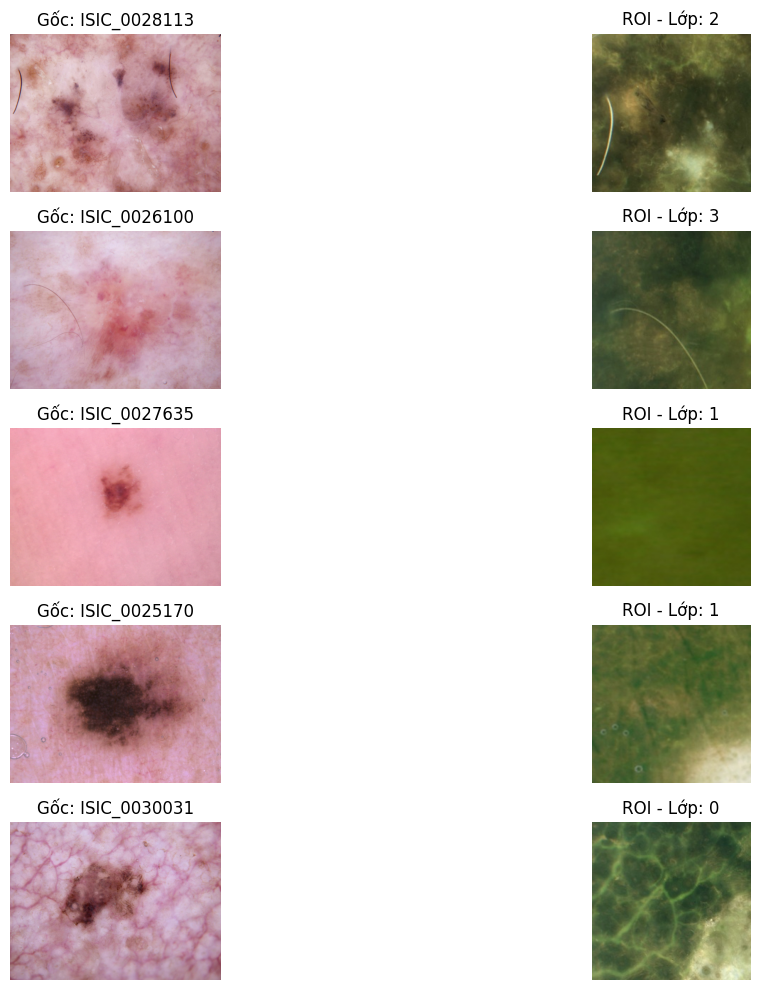

In [ ]:
# Hiển thị ROI
import matplotlib.pyplot as plt
import random
import os
import cv2

def show_original_and_roi(roi_root_dir, num_images=5):
    all_images = []
    for cls in os.listdir(roi_root_dir):
        cls_dir = os.path.join(roi_root_dir, cls)
        if os.path.isdir(cls_dir):
            all_images += [(os.path.join(cls_dir, img), cls) for img in os.listdir(cls_dir) if img.endswith(".jpg")]

    sample_images = random.sample(all_images, min(num_images, len(all_images)))

    plt.figure(figsize=(15, num_images * 2))

    for i, (roi_path, cls) in enumerate(sample_images):
        image_id = os.path.basename(roi_path).replace('.jpg', '')
        original_path = os.path.join(img_dir, image_id + '.jpg')

        # Load images
        roi_img = cv2.imread(roi_path)
        roi_img = cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB)

        original_img = cv2.imread(original_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # Show original
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(original_img)
        plt.title(f"Gốc: {image_id}")
        plt.axis("off")

        # Show ROI
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(roi_img)
        plt.title(f"ROI - Lớp: {cls}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Gọi hàm với tập train
show_original_and_roi('/content/roi/train', num_images=5)


In [ ]:
import os

# Thư mục chứa ảnh ROI của tập train và val
roi_dir = '/content/drive/MyDrive/ISIC_2018/RoiTest'
train_roi_dir = '/content/drive/MyDrive/ISIC_2018/RoiTest/train'
val_roi_dir = '/content/drive/MyDrive/ISIC_2018/RoiTest/val'

# Ánh xạ label sang tên bệnh
label_map = {
    "0": "Actinic keratoses",
    "1": "Basal cell carcinoma",
    "2": "Benign keratosis-like lesions",
    "3": "Dermatofibroma",
    "4": "Melanoma",
    "5": "Melanocytic nevi",
    "6": "Vascular lesions"
}

def count_roi_images(roi_dir):
    roi_counts = {}
    for label_name in sorted(os.listdir(roi_dir)):
        label_path = os.path.join(roi_dir, label_name)
        if os.path.isdir(label_path):
            num_images = len([f for f in os.listdir(label_path) if f.endswith('.jpg')])
            roi_counts[label_name] = num_images
    return roi_counts

# Đếm ảnh ROI
train_counts = count_roi_images(train_roi_dir)
val_counts = count_roi_images(val_roi_dir)

# In kết quả
print("=== Tập TRAIN ===")
print(f"Số loại bệnh: {len(train_counts)}")
for label, count in train_counts.items():
    print(f"  - {label_map.get(label, 'Không rõ')} (Label {label}): {count} ảnh ROI")

print("\n=== Tập VAL ===")
print(f"Số loại bệnh: {len(val_counts)}")
for label, count in val_counts.items():
    print(f"  - {label_map.get(label, 'Không rõ')} (Label {label}): {count} ảnh ROI")


=== Tập TRAIN ===
Số loại bệnh: 7
  - Actinic keratoses (Label 0): 779 ảnh ROI
  - Basal cell carcinoma (Label 1): 4695 ảnh ROI
  - Benign keratosis-like lesions (Label 2): 360 ảnh ROI
  - Dermatofibroma (Label 3): 229 ảnh ROI
  - Melanoma (Label 4): 770 ảnh ROI
  - Melanocytic nevi (Label 5): 81 ảnh ROI
  - Vascular lesions (Label 6): 99 ảnh ROI

=== Tập VAL ===
Số loại bệnh: 7
  - Actinic keratoses (Label 0): 167 ảnh ROI
  - Basal cell carcinoma (Label 1): 1004 ảnh ROI
  - Benign keratosis-like lesions (Label 2): 77 ảnh ROI
  - Dermatofibroma (Label 3): 49 ảnh ROI
  - Melanoma (Label 4): 164 ảnh ROI
  - Melanocytic nevi (Label 5): 17 ảnh ROI
  - Vascular lesions (Label 6): 21 ảnh ROI


Train VGG16 ( Lưu checkpoint nên em load lên và train nhiều lần như bên dưới)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

# === Đường dẫn ===
roi_dir = '/content/drive/MyDrive/ISIC_2018/RoiTest'
drive_model_path = '/content/drive/MyDrive/vgg16_best.h5'
drive_epoch_path = '/content/drive/MyDrive/vgg16_epoch.txt'
history_save_path = '/content/drive/MyDrive/vgg16_history.npz'

# === Data generators ===
train_gen = ImageDataGenerator(
    rotation_range=30, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
    brightness_range=[0.8, 1.2], width_shift_range=0.1, height_shift_range=0.1, fill_mode='nearest')
val_gen = ImageDataGenerator()

train_generator = train_gen.flow_from_directory(
    os.path.join(roi_dir, 'train'), target_size=(224, 224), batch_size=32, class_mode='sparse')
val_generator = val_gen.flow_from_directory(
    os.path.join(roi_dir, 'val'), target_size=(224, 224), batch_size=32, class_mode='sparse')

# === Class weights ===
labels = train_generator.classes
cw = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(cw))

# === Epoch bắt đầu ===
initial_epoch = 0
if os.path.exists(drive_model_path):
    print("Loading VGG16...")
    model_cls = load_model(drive_model_path)

    for layer in model_cls.layers:
        layer.trainable = True

    model_cls.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    if os.path.exists(drive_epoch_path):
        with open(drive_epoch_path, 'r') as f:
            initial_epoch = int(f.read().strip())
            print(f"Tiếp tục training từ epoch {initial_epoch}")

else:
    print("Training VGG16 từ đầu...")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = Flatten()(base_model.output)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model_cls = Model(base_model.input, out)

    for layer in base_model.layers:
        layer.trainable = False

    model_cls.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_cls.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        class_weight=class_weights
    )

    # Fine-tune tiếp
    for layer in model_cls.layers:
        layer.trainable = True
    model_cls.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# === Callback lưu epoch ===
class EpochSaver(Callback):
    def __init__(self, path):
        super().__init__()
        self.path = path
    def on_epoch_end(self, epoch, logs=None):
        with open(self.path, 'w') as f:
            f.write(str(epoch + 1))

# === Checkpoint và training chính ===
ckpt = ModelCheckpoint(drive_model_path, save_best_only=True, monitor='val_loss', verbose=1)

history = model_cls.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=initial_epoch,
    epochs=40,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ckpt,
        EpochSaver(drive_epoch_path)
    ]
)

# === Lưu history ===
np.savez(history_save_path, **history.history)
print(f"Lưu lịch sử training vào {history_save_path}")


Found 7013 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
Training VGG16 từ đầu...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 2813s 12s/step - accuracy: 0.4674 - loss: 8.6962 - val_accuracy: 0.5329 - val_loss: 4.5046
Epoch 1: val_loss improved from inf to 4.50463, saving model to None
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 128s 579ms/step - accuracy: 0.5060 - loss: 7.6680 - val_accuracy: 0.5442 - val_loss: 4.0861
Epoch 2: val_loss improved from 4.50463 to 4.08610, saving model to None
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 591ms/step - accuracy: 0.5069 - loss: 7.1054 - val_accuracy: 0.4762 - val_loss: 4.4405
Epoch 3: val_loss did not improve from 4.08610
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 590ms/step - accuracy: 0.5113 - loss: 6.5139 - val_accuracy: 0.6636 - val_loss: 3.2248
Epoch 4: val_loss improved from 4.08610 to 3.22483, saving model to None
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 129s 586ms/step - accuracy: 0.5211 - loss: 6.5824 - val_accuracy: 0.7264 - val_loss: 2.7875
Epoch 5: val_loss improved from 3.22483 to 2.78754, saving model to None
Epoch 

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

# === Đường dẫn ===
roi_dir = '/content/drive/MyDrive/ISIC_2018/RoiTest'
drive_model_path = '/content/drive/MyDrive/vgg16_best.h5'
drive_epoch_path = '/content/drive/MyDrive/vgg16_epoch.txt'
history_save_path = '/content/drive/MyDrive/vgg16_history.npz'

# === Data generators ===
train_gen = ImageDataGenerator(
    rotation_range=30, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
    brightness_range=[0.8, 1.2], width_shift_range=0.1, height_shift_range=0.1, fill_mode='nearest')
val_gen = ImageDataGenerator()

train_generator = train_gen.flow_from_directory(
    os.path.join(roi_dir, 'train'), target_size=(224, 224), batch_size=32, class_mode='sparse')
val_generator = val_gen.flow_from_directory(
    os.path.join(roi_dir, 'val'), target_size=(224, 224), batch_size=32, class_mode='sparse')

# === Class weights ===
labels = train_generator.classes
cw = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(cw))

# === Epoch bắt đầu ===
initial_epoch = 0
if os.path.exists(drive_model_path):
    print("Loading VGG16...")
    model_cls = load_model(drive_model_path)

    for layer in model_cls.layers:
        layer.trainable = True

    model_cls.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    if os.path.exists(drive_epoch_path):
        with open(drive_epoch_path, 'r') as f:
            initial_epoch = int(f.read().strip())
            print(f"Tiếp tục training từ epoch {initial_epoch}")

else:
    print("Training VGG16 từ đầu...")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = Flatten()(base_model.output)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model_cls = Model(base_model.input, out)

    for layer in base_model.layers:
        layer.trainable = False

    model_cls.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_cls.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        class_weight=class_weights
    )

    # Fine-tune tiếp
    for layer in model_cls.layers:
        layer.trainable = True
    model_cls.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# === Callback lưu epoch ===
class EpochSaver(Callback):
    def __init__(self, path):
        super().__init__()
        self.path = path
    def on_epoch_end(self, epoch, logs=None):
        with open(self.path, 'w') as f:
            f.write(str(epoch + 1))

# === Checkpoint và training chính ===
ckpt = ModelCheckpoint(drive_model_path, save_best_only=True, monitor='val_loss', verbose=1)

history = model_cls.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=initial_epoch,
    epochs=40,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ckpt,
        EpochSaver(drive_epoch_path)
    ]
)

# === Lưu history ===
np.savez(history_save_path, **history.history)
print(f"Lưu lịch sử training vào {history_save_path}")


Found 7013 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
Loading VGG16...
Tiếp tục training từ epoch 14


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 15/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 170s 773ms/step - accuracy: 0.6215 - loss: 1.3571 - val_accuracy: 0.5682 - val_loss: 1.3849
Epoch 15: val_loss improved from inf to 1.38486, saving model to /content/drive/MyDrive/vgg16_best.h5
Epoch 16/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 162s 736ms/step - accuracy: 0.6325 - loss: 1.2929 - val_accuracy: 0.5316 - val_loss: 1.4332
Epoch 16: val_loss did not improve from 1.38486
Epoch 17/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 156s 707ms/step - accuracy: 0.6353 - loss: 1.2710 - val_accuracy: 0.7010 - val_loss: 1.0791
Epoch 17: val_loss improved from 1.38486 to 1.07912, saving model to /content/drive/MyDrive/vgg16_best.h5
Epoch 18/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 160s 725ms/step - accuracy: 0.6430 - loss: 1.2280 - val_accuracy: 0.6656 - val_loss: 1.1773
Epoch 18: val_loss did not improve from 1.07912
Epoch 19/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 152s 692ms/step - accuracy: 0.6383 - loss: 1.2455 - val_accuracy: 0.6343 - val_loss: 1.2680
Epoch 19: val_loss did not impr

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

# === Đường dẫn ===
roi_dir = '/content/drive/MyDrive/ISIC_2018/RoiTest'
drive_model_path = '/content/drive/MyDrive/vgg16_best.h5'
drive_epoch_path = '/content/drive/MyDrive/vgg16_epoch.txt'
history_save_path = '/content/drive/MyDrive/vgg16_history.npz'

# === Data generators ===
train_gen = ImageDataGenerator(
    rotation_range=30, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
    brightness_range=[0.8, 1.2], width_shift_range=0.1, height_shift_range=0.1, fill_mode='nearest')
val_gen = ImageDataGenerator()

train_generator = train_gen.flow_from_directory(
    os.path.join(roi_dir, 'train'), target_size=(224, 224), batch_size=32, class_mode='sparse')
val_generator = val_gen.flow_from_directory(
    os.path.join(roi_dir, 'val'), target_size=(224, 224), batch_size=32, class_mode='sparse')

# === Class weights ===
labels = train_generator.classes
cw = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(cw))

# === Epoch bắt đầu ===
initial_epoch = 0
if os.path.exists(drive_model_path):
    print("Loading VGG16...")
    model_cls = load_model(drive_model_path)

    for layer in model_cls.layers:
        layer.trainable = True

    model_cls.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    if os.path.exists(drive_epoch_path):
        with open(drive_epoch_path, 'r') as f:
            initial_epoch = int(f.read().strip())
            print(f"Tiếp tục training từ epoch {initial_epoch}")

else:
    print("Training VGG16 từ đầu...")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = Flatten()(base_model.output)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model_cls = Model(base_model.input, out)

    for layer in base_model.layers:
        layer.trainable = False

    model_cls.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_cls.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        class_weight=class_weights
    )

    # Fine-tune tiếp
    for layer in model_cls.layers:
        layer.trainable = True
    model_cls.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# === Callback lưu epoch ===
class EpochSaver(Callback):
    def __init__(self, path):
        super().__init__()
        self.path = path
    def on_epoch_end(self, epoch, logs=None):
        with open(self.path, 'w') as f:
            f.write(str(epoch + 1))

# === Checkpoint và training chính ===
ckpt = ModelCheckpoint(drive_model_path, save_best_only=True, monitor='val_loss', verbose=1)

history = model_cls.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=initial_epoch,
    epochs=40,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ckpt,
        EpochSaver(drive_epoch_path)
    ]
)

# === Lưu history ===
np.savez(history_save_path, **history.history)
print(f"Lưu lịch sử training vào {history_save_path}")


Found 7013 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
Loading VGG16...
Tiếp tục training từ epoch 22


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 23/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 169s 769ms/step - accuracy: 0.6566 - loss: 1.2742 - val_accuracy: 0.5883 - val_loss: 1.4089
Epoch 23: val_loss improved from inf to 1.40886, saving model to /content/drive/MyDrive/vgg16_best.h5
Epoch 24/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 163s 738ms/step - accuracy: 0.6265 - loss: 1.2415 - val_accuracy: 0.6957 - val_loss: 1.0931
Epoch 24: val_loss improved from 1.40886 to 1.09306, saving model to /content/drive/MyDrive/vgg16_best.h5
Epoch 25/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 160s 725ms/step - accuracy: 0.6503 - loss: 1.2115 - val_accuracy: 0.6096 - val_loss: 1.2501
Epoch 25: val_loss did not improve from 1.09306
Epoch 26/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 155s 702ms/step - accuracy: 0.6620 - loss: 1.1577 - val_accuracy: 0.6603 - val_loss: 1.1829
Epoch 26: val_loss did not improve from 1.09306
Epoch 27/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 714ms/step - accuracy: 0.6624 - loss: 1.1585 - val_accuracy: 0.7310 - val_loss: 1.0275
Epoch 27: val_loss improved fro

Đánh giá mô hình

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step


<Figure size 800x800 with 0 Axes>

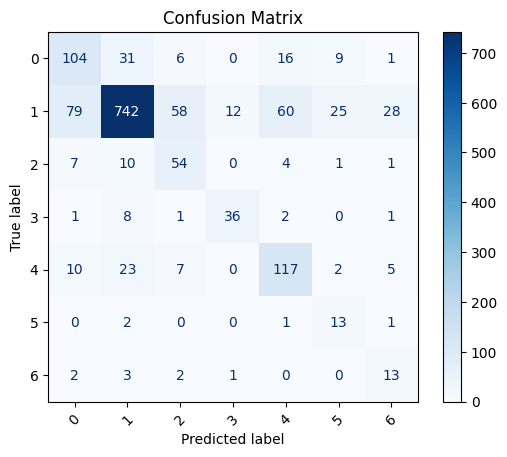

Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.62      0.56       167
           1       0.91      0.74      0.81      1004
           2       0.42      0.70      0.53        77
           3       0.73      0.73      0.73        49
           4       0.58      0.71      0.64       164
           5       0.26      0.76      0.39        17
           6       0.26      0.62      0.37        21

    accuracy                           0.72      1499
   macro avg       0.53      0.70      0.58      1499
weighted avg       0.78      0.72      0.74      1499



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

val_steps = val_generator.samples // val_generator.batch_size + 1
y_true = val_generator.classes
y_pred_probs = model_cls.predict(val_generator, steps=val_steps)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = list(val_generator.class_indices.keys())
n_classes = len(class_names)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
